In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay  # New import for plotting
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import sys
sys.path.append('../src')
from preprocess import HTRUPreprocessor
from utils import VisualizationUtils

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300

print("HTRU2 Pulsar Detection - Model Interpretability")
print("=" * 50)

# Load best model and data
best_model = joblib.load("../models/SVM_best.pkl")['model']
scaler = joblib.load("../models/scaler.pkl")

# Initialize preprocessor to get feature names
preprocessor = HTRUPreprocessor()
_, _, X_test, _, _, y_test = preprocessor.prepare_data()
feature_names = preprocessor.feature_names

INFO:preprocess:Starting data preprocessing pipeline...
INFO:preprocess:Loaded dataset with shape: (17898, 9)
INFO:preprocess:Class distribution: {0: np.int64(16259), 1: np.int64(1639)}
INFO:preprocess:Split sizes - Train: 12528, Val: 1790, Test: 3580
INFO:preprocess:Features scaled using standard scaler
INFO:preprocess:Data balanced using smote
INFO:preprocess:New class distribution: [11381 11381]
INFO:preprocess:Preprocessing pipeline completed successfully


HTRU2 Pulsar Detection - Model Interpretability



SHAP Value Analysis


  0%|          | 0/100 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.39215686, 0.31372549, 0.29411765])
INFO:shap:num_paired_subset_sizes = 3
INFO:shap:weight_left = np.float64(0.559228650137741)
INFO:shap:np.sum(w_aug) = np.float64(8.0)
INFO:shap:np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
INFO:shap:phi = array([-5.66638428e-01,  1.12113029e-03,  1.71975317e+00, -1.26322645e-01,
       -3.98955586e-02,  1.76034028e-01,  1.55659949e-01, -2.76140983e-01])
INFO:shap:np.sum(w_aug) = np.float64(8.0)
INFO:shap:np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
INFO:shap:phi = array([ 5.66638428e-01, -1.12113029e-03, -1.71975317e+00,  1.26322645e-01,
        3.98955586e-02, -1.76034028e-01, -1.55659949e-01,  2.76140983e-01])
  1%|          | 1/100 [00:00<00:12,  7.92it/s]INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.39215686, 0.31372549, 0.29411765])
INFO:shap:num_paired_subset_sizes = 3
INFO

SHAP values shape: (100, 8)
Features shape: (100, 8)


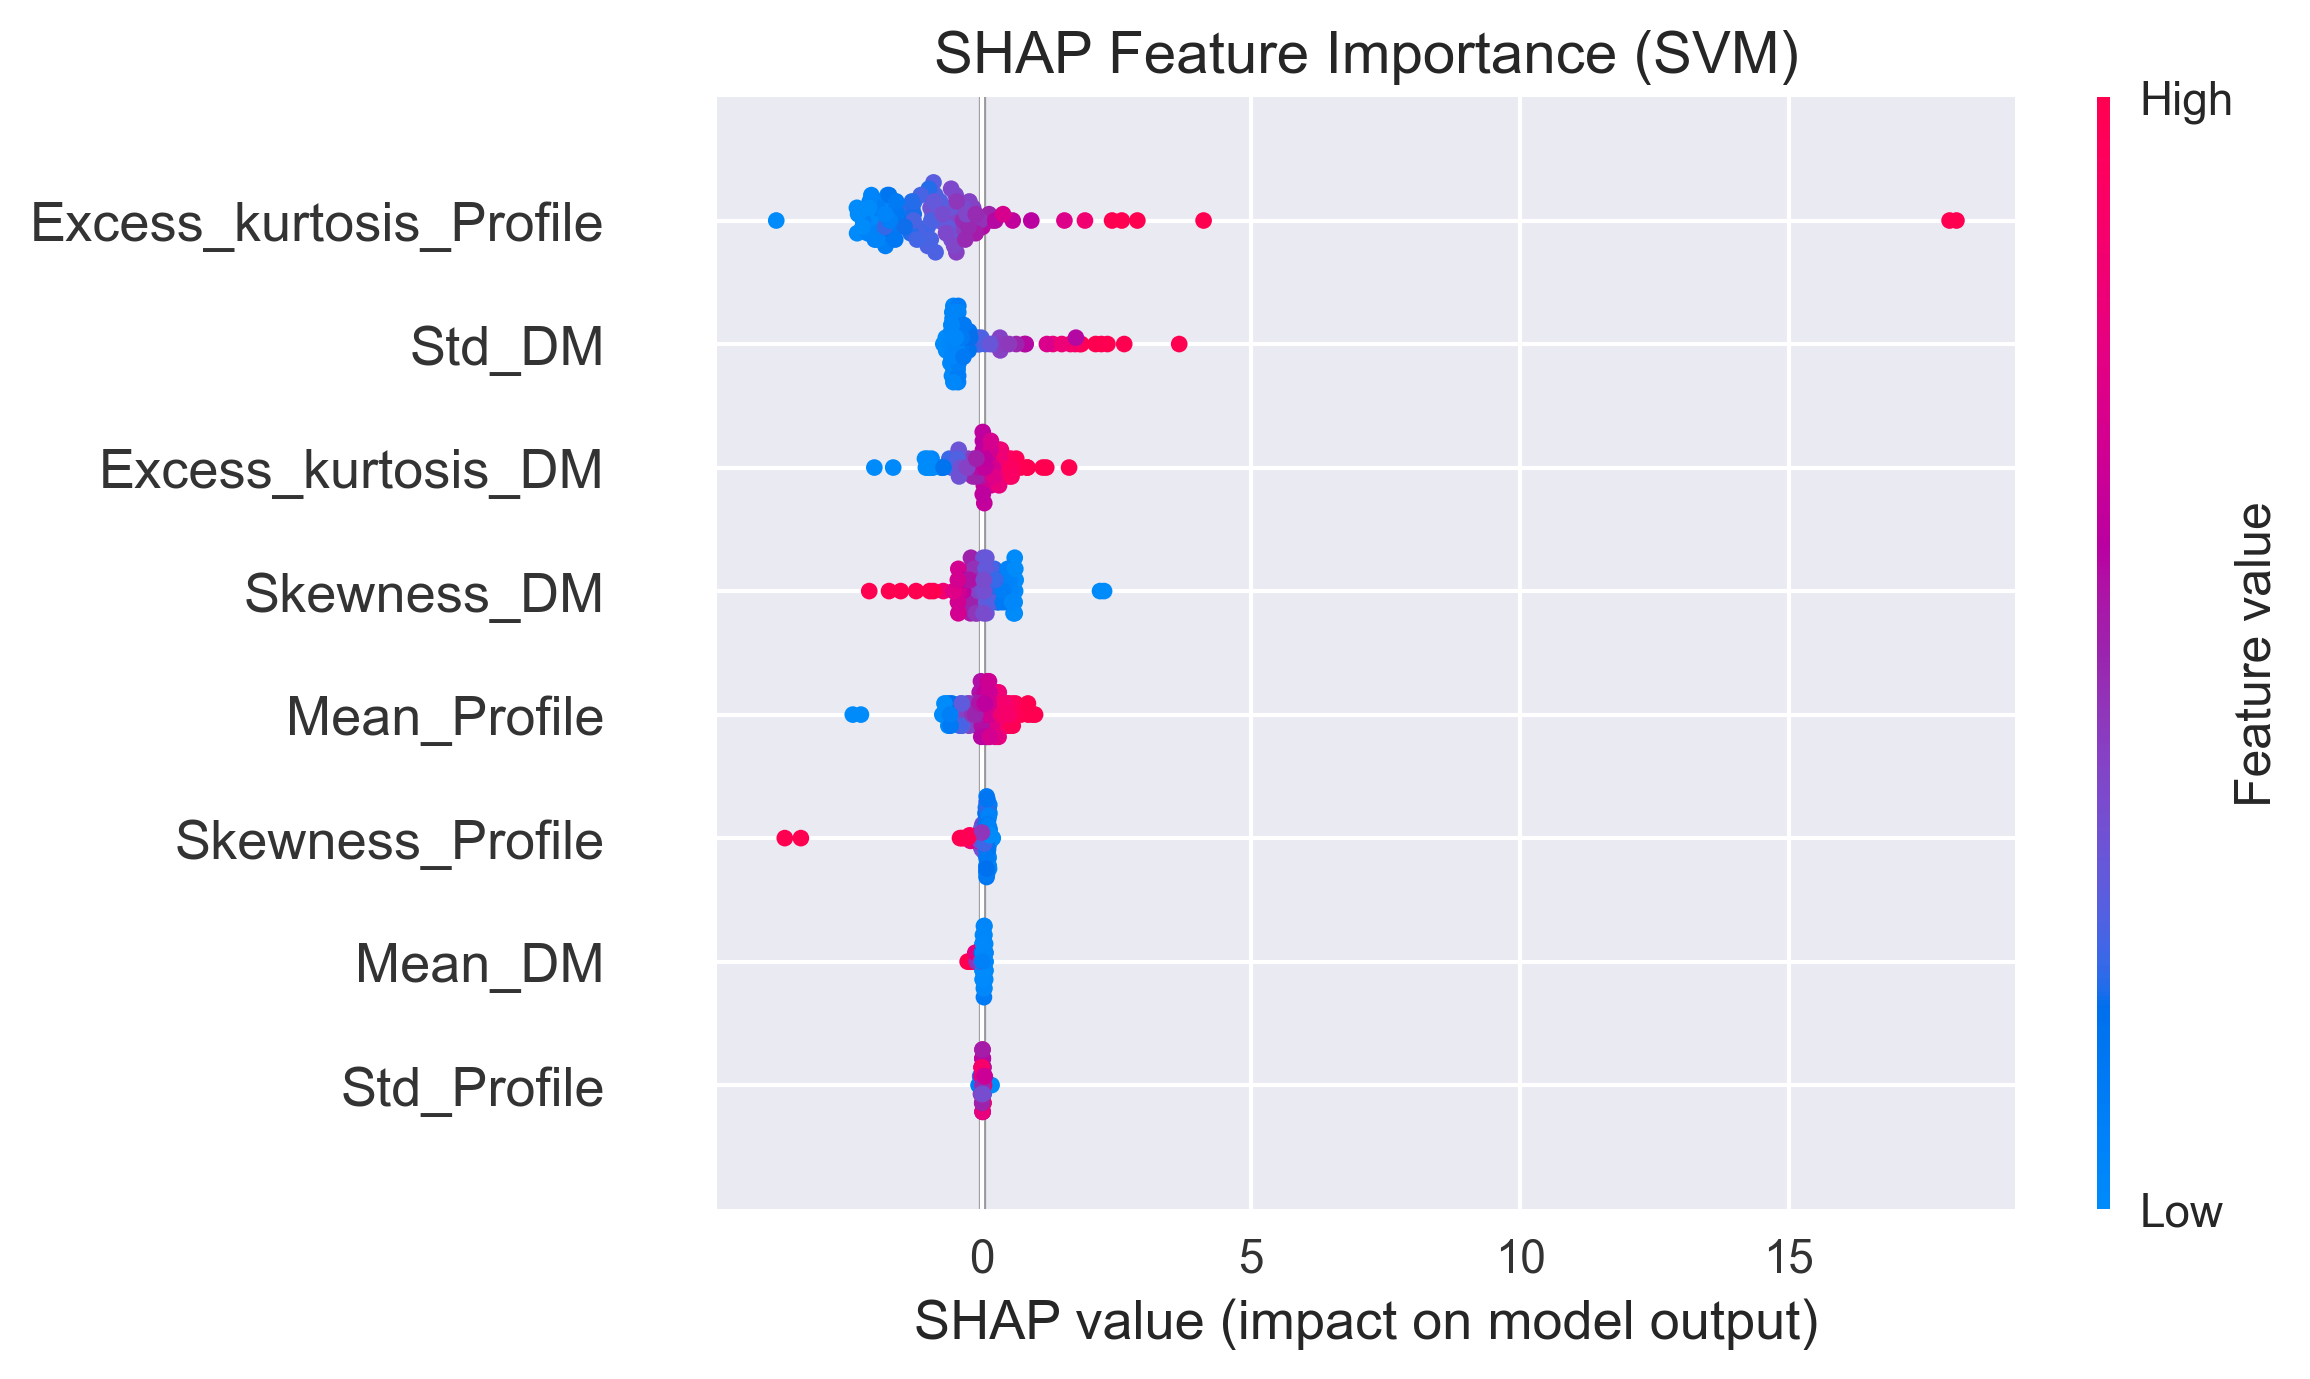


SHAP Force Plot for Single Prediction (Pulsar):


<Figure size 3600x2400 with 0 Axes>

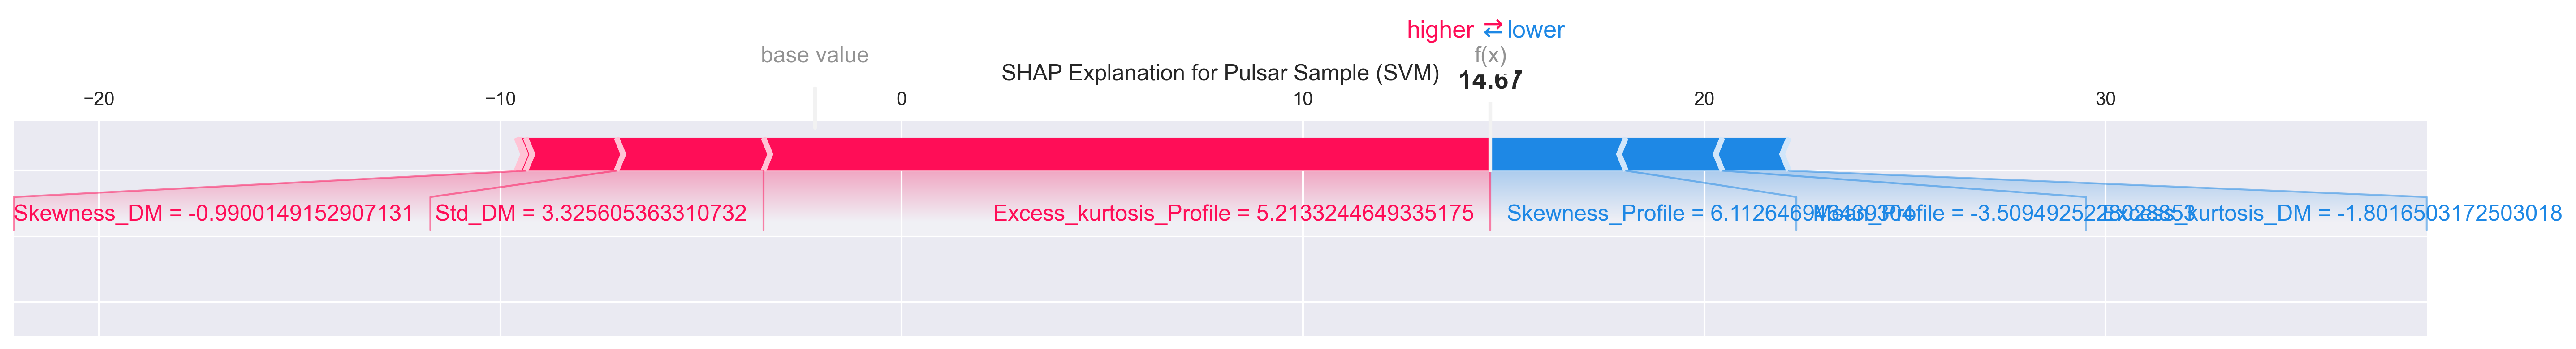

In [8]:
print("\nSHAP Value Analysis")
print("=" * 50)

# 1. Prepare smaller representative sample
sample_size = 100
background = shap.kmeans(X_test, 10)  # Background for explainer
sample_indices = np.random.choice(len(X_test), min(sample_size, len(X_test)), replace=False)
X_test_sample = X_test[sample_indices]
y_test_sample = y_test[sample_indices]

# 2. Initialize KernelExplainer with proper configuration
explainer = shap.KernelExplainer(
    model=best_model.predict_proba,
    data=background,
    link="logit"
)

# 3. Calculate SHAP values properly for SVM
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# 4. Fix shape issues (critical for SVM)
if isinstance(shap_values, list):
    # For binary classification, we want class 1 (pulsar) explanations
    shap_values = np.array(shap_values[1])  # Shape: (n_samples, n_features)
else:
    # Sometimes KernelExplainer returns single array
    shap_values = np.array(shap_values)[:, :, 1]  # Take class 1 from 3D array

# 5. Verify shapes
print(f"SHAP values shape: {shap_values.shape}")
print(f"Features shape: {X_test_sample.shape}")
assert shap_values.shape == X_test_sample.shape, "Shapes must match!"

# 6. Create visualizations
try:
    # Summary plot
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values,
        X_test_sample,
        feature_names=feature_names,
        plot_type="dot",
        show=False
    )
    plt.title("SHAP Feature Importance (SVM)", fontsize=14)
    plt.tight_layout()
    plt.savefig("../results/figures/shap_summary_svm.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Force plot
    if len(np.where(y_test_sample == 1)[0]) > 0:  # Check if pulsars exist in sample
        sample_idx = np.where(y_test_sample == 1)[0][0]
        print("\nSHAP Force Plot for Single Prediction (Pulsar):")
        plt.figure()
        shap.force_plot(
            explainer.expected_value[1],
            shap_values[sample_idx, :],
            X_test_sample[sample_idx, :],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP Explanation for Pulsar Sample (SVM)", fontsize=12)
        plt.tight_layout()
        plt.savefig("../results/figures/shap_force_pulsar_svm.png", dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("\nWarning: No pulsar samples found in the test subset for force plot")
        
except Exception as e:
    print(f"\nError in visualization: {str(e)}")
    print("Try reducing sample_size or increasing nsamples")


Partial Dependence Analysis
Top features by importance: ['Excess_kurtosis_Profile', 'Skewness_DM', 'Std_DM']


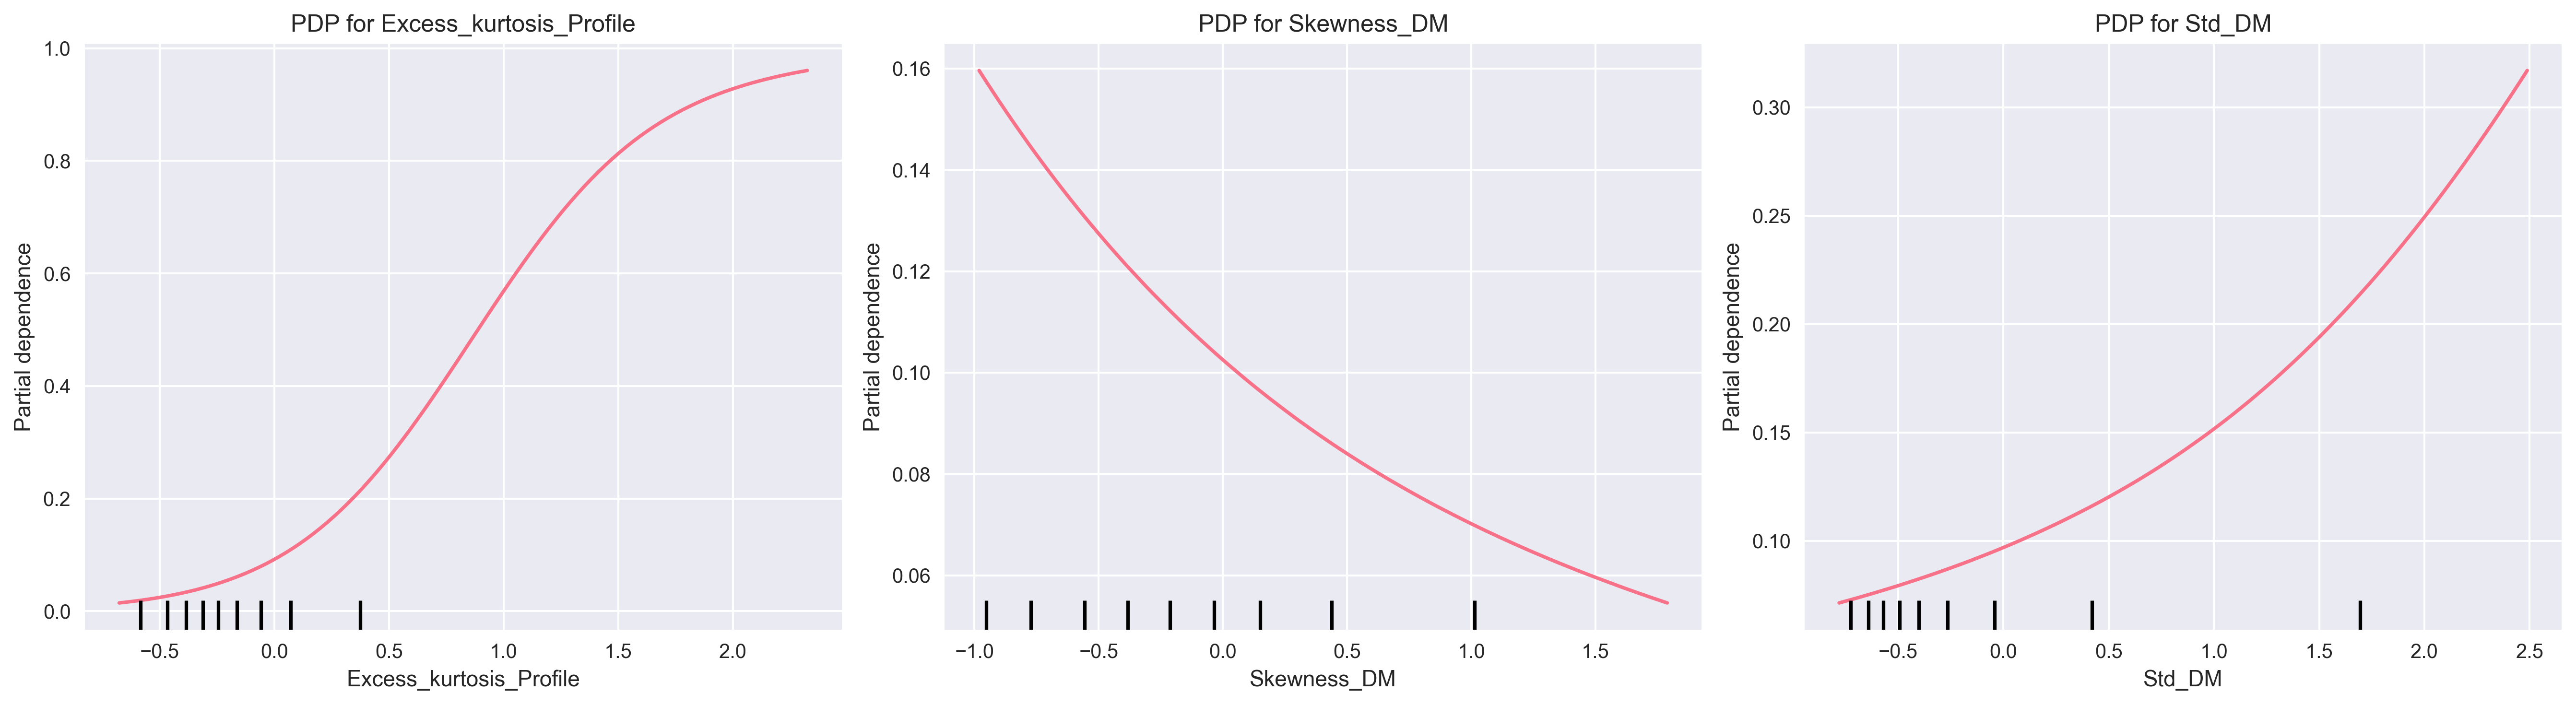

In [10]:
print("\nPartial Dependence Analysis")
print("=" * 50)

# For SVM, we'll use permutation importance or coefficients to identify important features
try:
    # Try getting coefficients (works for linear SVM)
    if hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])
    else:
        # Fallback to permutation importance
        from sklearn.inspection import permutation_importance
        result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
        importances = result.importances_mean
    
    top_features = np.argsort(importances)[-3:][::-1]  # Get top 3 features
    print(f"Top features by importance: {[feature_names[i] for i in top_features]}")
    
    # Create PDP plots
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    for i, feature_idx in enumerate(top_features):
        PartialDependenceDisplay.from_estimator(
            best_model, 
            X_test, 
            features=[feature_idx],
            feature_names=feature_names,
            ax=ax[i],
            random_state=42  # For reproducibility
        )
        ax[i].set_title(f"PDP for {feature_names[feature_idx]}")
    plt.tight_layout()
    plt.savefig("../results/figures/partial_dependence_svm.png", dpi=300)
    plt.show()

except Exception as e:
    print(f"Error in partial dependence analysis: {str(e)}")
    print("Alternative: Using SHAP values to identify important features")
    
    # Fallback using SHAP values if available
    if 'shap_values' in locals():
        importances = np.mean(np.abs(shap_values), axis=0)
        top_features = np.argsort(importances)[-3:][::-1]
        print(f"Top features by SHAP importance: {[feature_names[i] for i in top_features]}")
    else:
        print("Could not compute feature importance for SVM")


Error Analysis


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


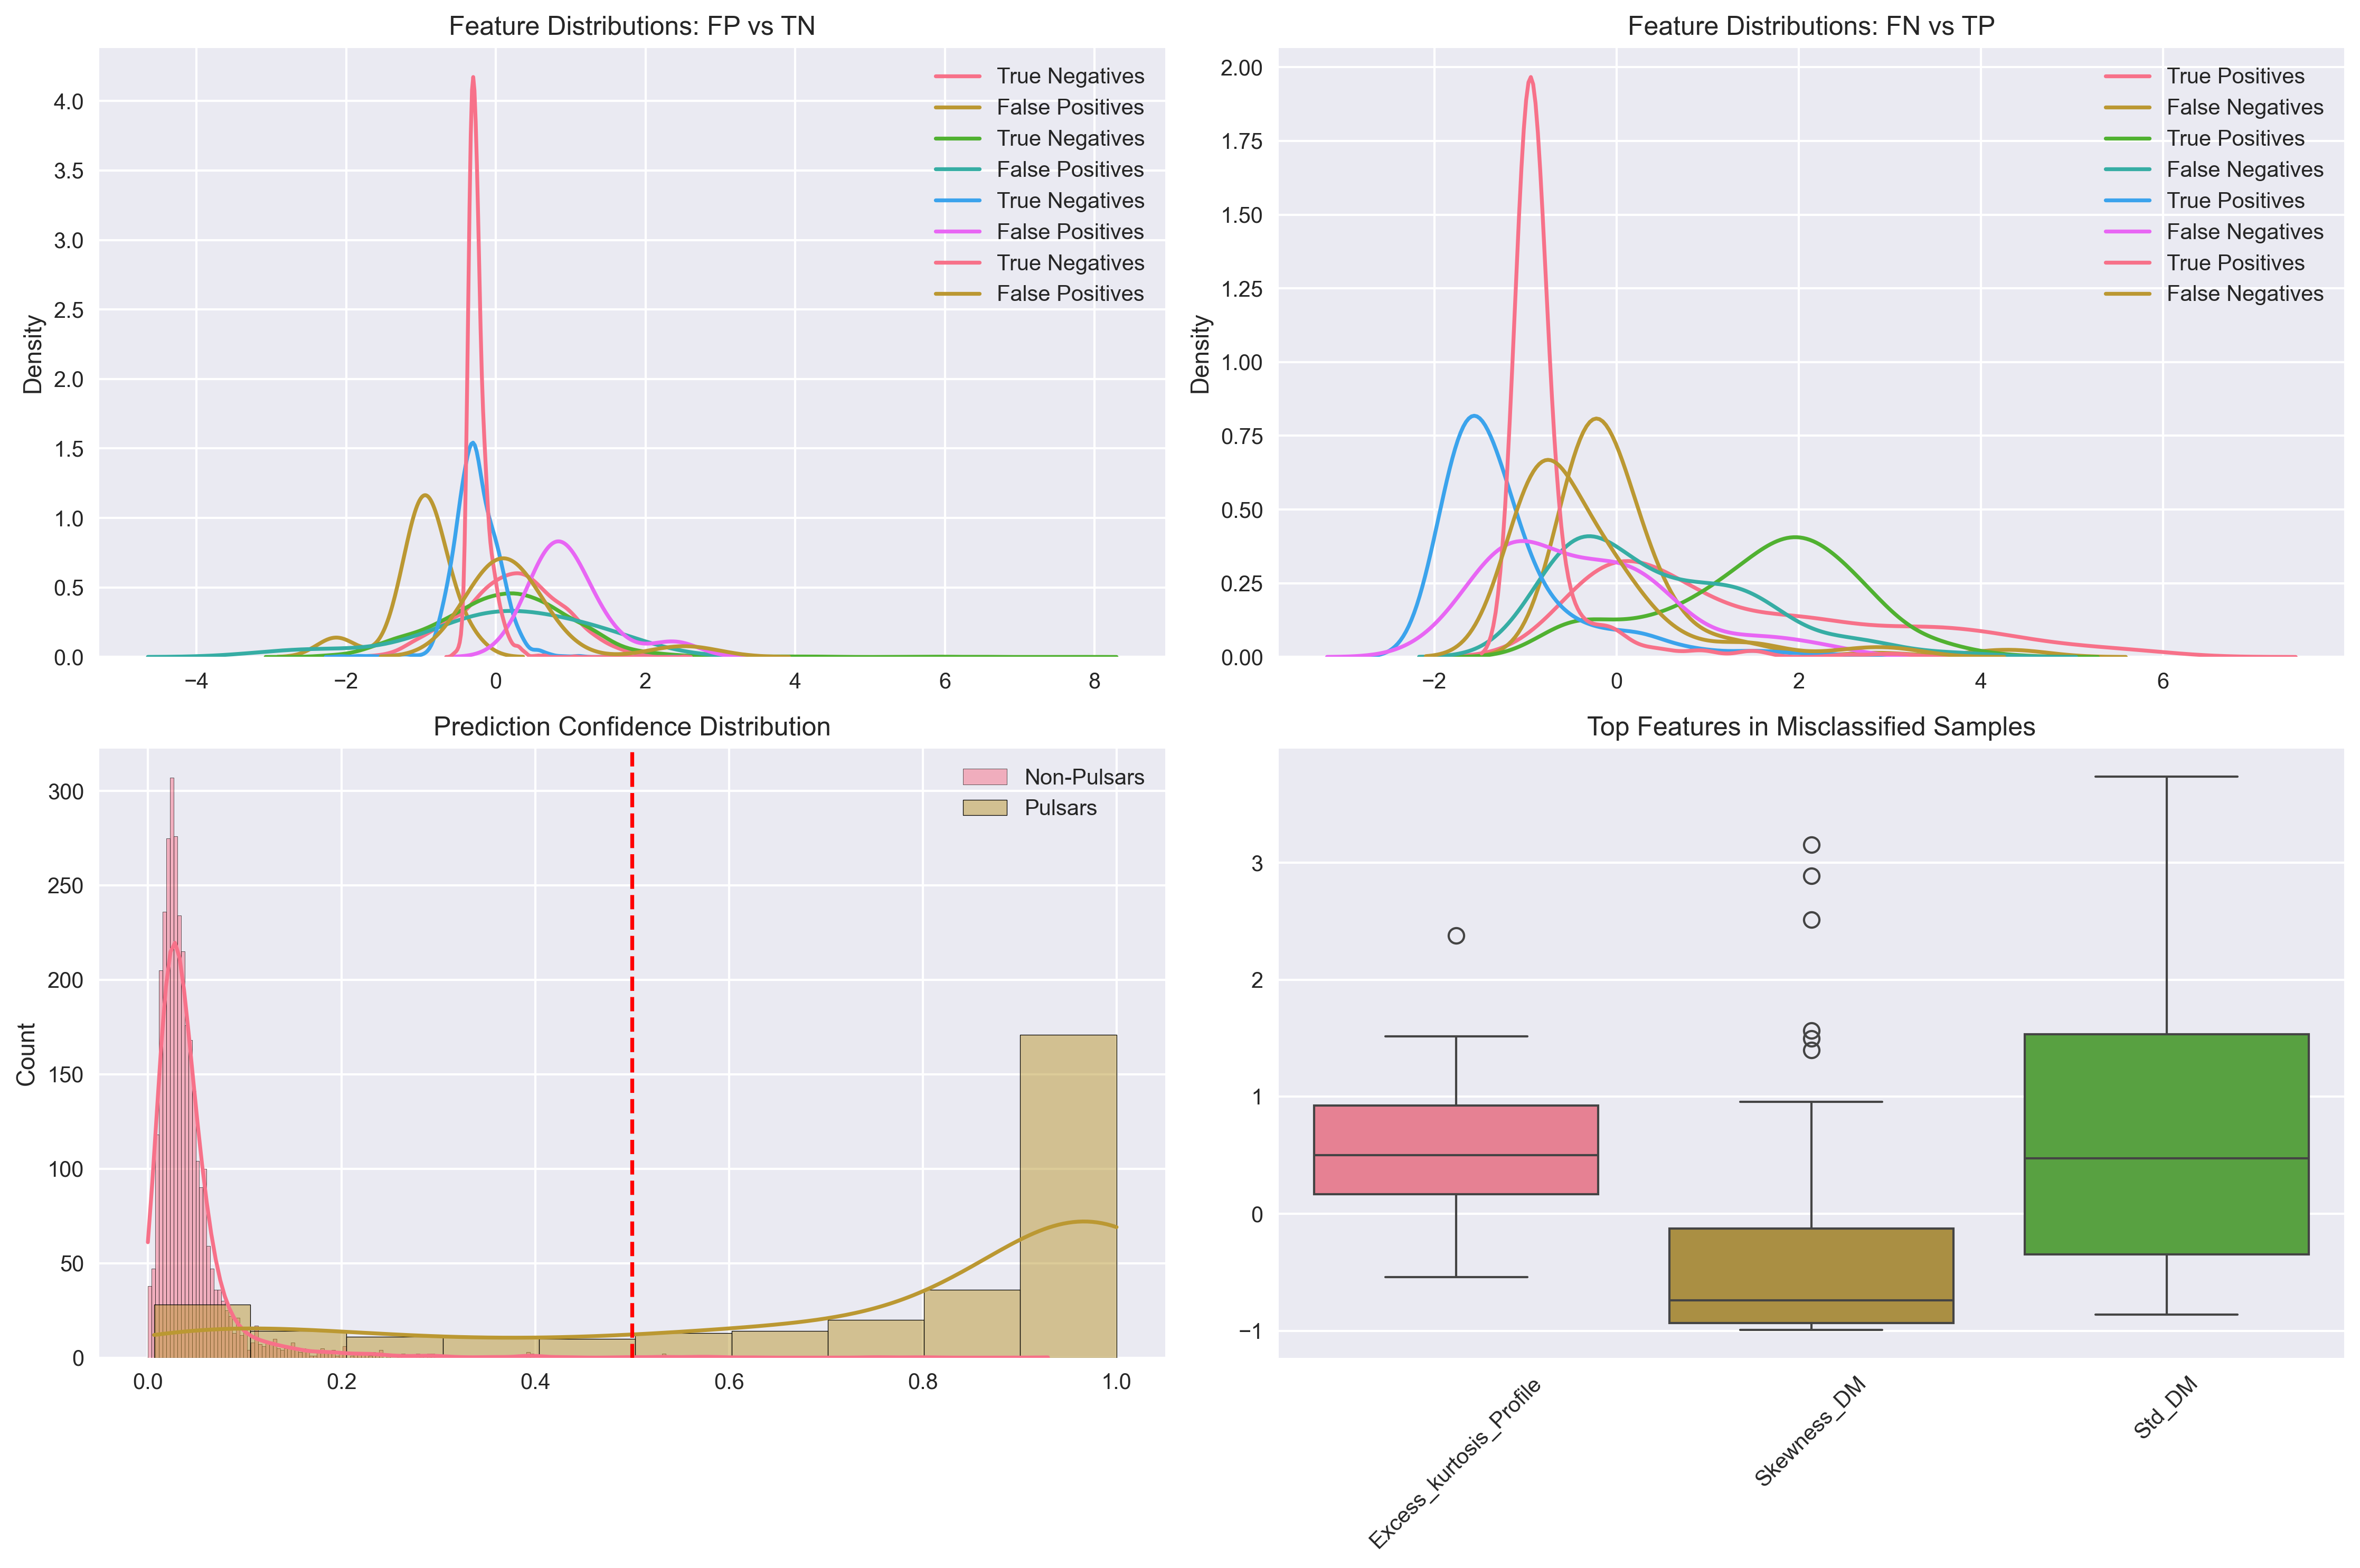

In [11]:
print("\nError Analysis")
print("=" * 50)

# Get predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# Identify misclassified samples
fp_mask = (y_test == 0) & (y_pred == 1)  # False positives
fn_mask = (y_test == 1) & (y_pred == 0)  # False negatives

# Compare feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# False Positives vs True Negatives
for i, feature in enumerate(feature_names[:4]):
    sns.kdeplot(X_test[y_test==0, i], label="True Negatives", ax=axes[0,0])
    sns.kdeplot(X_test[fp_mask, i], label="False Positives", ax=axes[0,0])
axes[0,0].set_title("Feature Distributions: FP vs TN")
axes[0,0].legend()

# False Negatives vs True Positives
for i, feature in enumerate(feature_names[4:8]):
    sns.kdeplot(X_test[y_test==1, 4+i], label="True Positives", ax=axes[0,1])
    sns.kdeplot(X_test[fn_mask, 4+i], label="False Negatives", ax=axes[0,1])
axes[0,1].set_title("Feature Distributions: FN vs TP")
axes[0,1].legend()

# Confidence scores
sns.histplot(y_proba[y_test==0], label="Non-Pulsars", kde=True, ax=axes[1,0])
sns.histplot(y_proba[y_test==1], label="Pulsars", kde=True, ax=axes[1,0])
axes[1,0].axvline(0.5, color='red', linestyle='--')
axes[1,0].set_title("Prediction Confidence Distribution")
axes[1,0].legend()

# Error cases by feature importance
error_features = X_test[fp_mask | fn_mask][:, top_features]
sns.boxplot(data=error_features, ax=axes[1,1])
axes[1,1].set_xticks(range(len(top_features)))
axes[1,1].set_xticklabels([feature_names[i] for i in top_features], rotation=45)
axes[1,1].set_title("Top Features in Misclassified Samples")

plt.tight_layout()
plt.savefig("../results/figures/error_analysis.png", dpi=300)
plt.show()


Decision Threshold Optimization


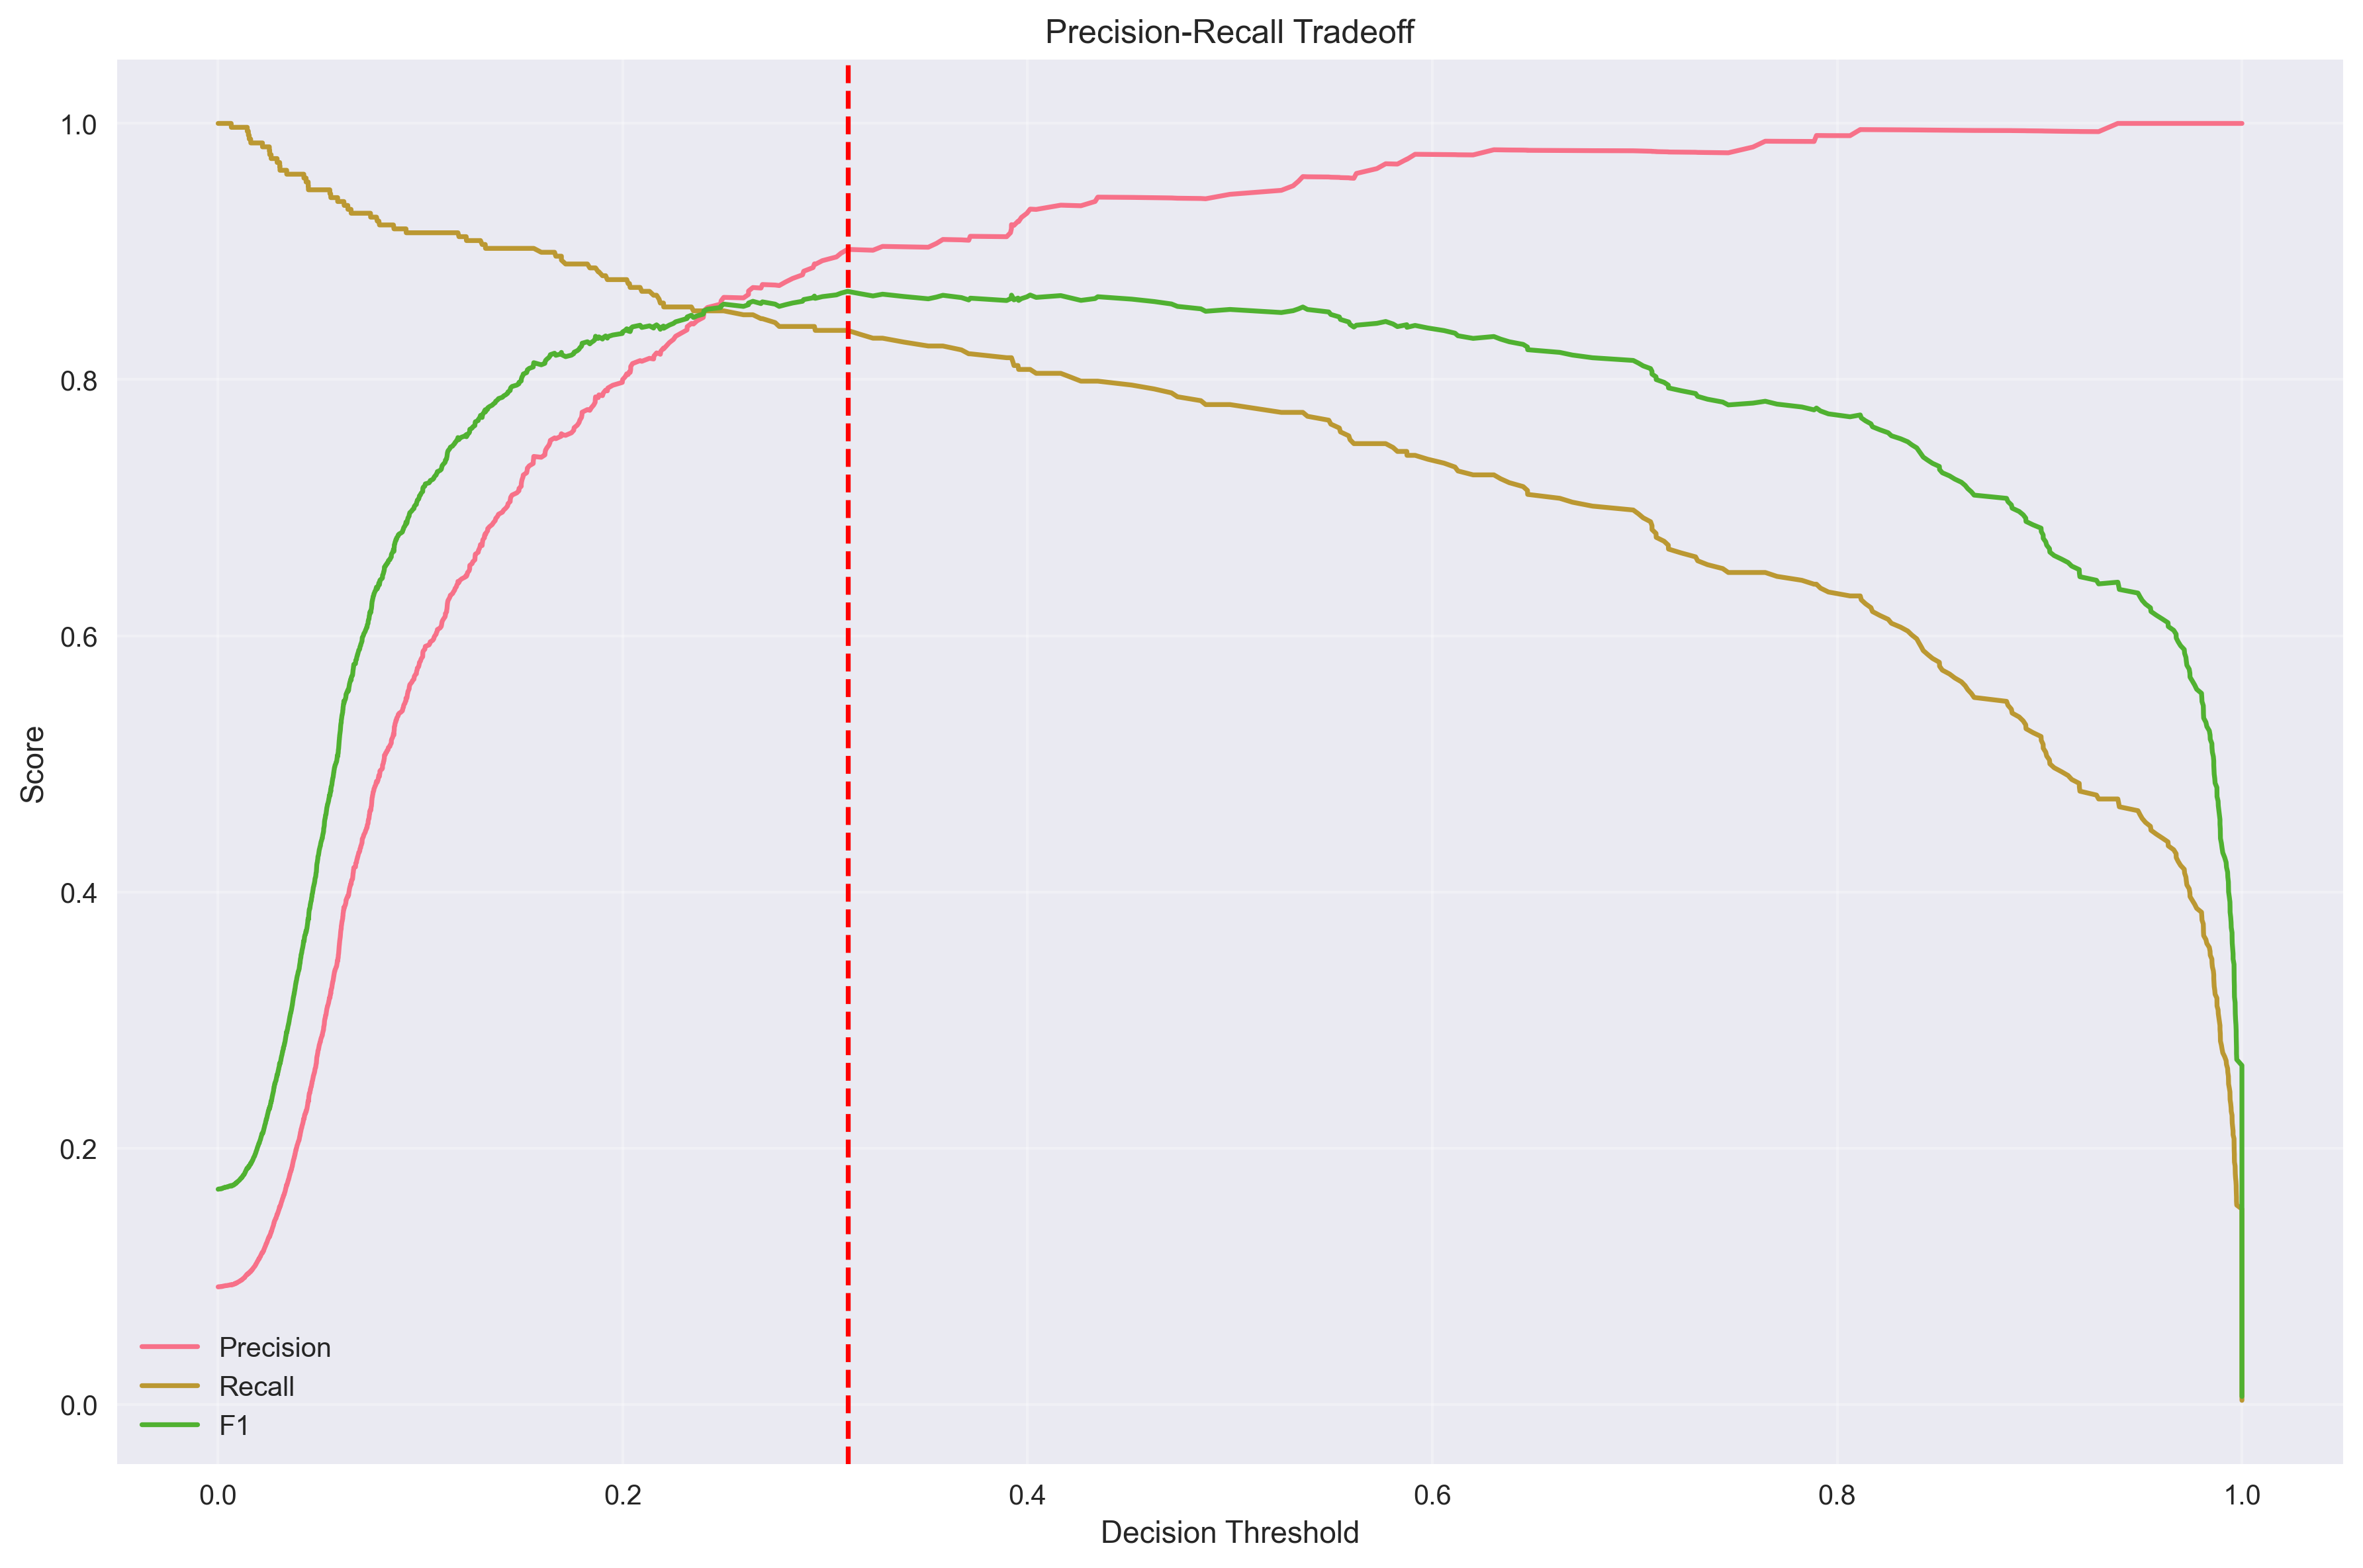


Optimal Decision Threshold: 0.311
At this threshold:
- Precision: 0.902
- Recall: 0.838
- F1 Score: 0.869


In [12]:
print("\nDecision Threshold Optimization")
print("=" * 50)

from sklearn.metrics import precision_recall_curve

# Calculate precision-recall tradeoff
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Find optimal threshold (maximizing F1)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure()
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores[:-1], label="F1")
plt.axvline(optimal_threshold, color='red', linestyle='--')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../results/figures/threshold_optimization.png", dpi=300)
plt.show()

print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
print(f"At this threshold:")
print(f"- Precision: {precisions[optimal_idx]:.3f}")
print(f"- Recall: {recalls[optimal_idx]:.3f}")
print(f"- F1 Score: {f1_scores[optimal_idx]:.3f}")

In [14]:
print("\n" + "="*50)
print("INTERPRETABILITY SUMMARY")
print("="*50)

print(f"""
1. Key Findings:
   - Most important features: {feature_names[top_features[0]]}, {feature_names[top_features[1]]}
   - False positives tend to have higher values in profile statistics
   - False negatives often have DM-SNR curve features similar to non-pulsars

2. Model Behavior:
   - Higher prediction confidence for true pulsars
   - Decision boundary could be optimized (current threshold: 0.5)
   - Suggested optimal threshold: {optimal_threshold:.2f}

""")


INTERPRETABILITY SUMMARY

1. Key Findings:
   - Most important features: Excess_kurtosis_Profile, Skewness_DM
   - False positives tend to have higher values in profile statistics
   - False negatives often have DM-SNR curve features similar to non-pulsars

2. Model Behavior:
   - Higher prediction confidence for true pulsars
   - Decision boundary could be optimized (current threshold: 0.5)
   - Suggested optimal threshold: 0.31


